## 1. Import Required Python Modules

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications import resnet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

## 2. Load and Preprocess Input Image

In [2]:
model = resnet50.ResNet50(weights='imagenet')
img_path = tf.keras.utils.get_file('macaw.png',
    'https://images.unsplash.com/photo-1612024782955-49fae79e42bb?q=80&w=687&auto=format&fit=crop&ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D')

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
input_img = resnet50.preprocess_input(np.expand_dims(img_array.copy(), axis=0))
input_tensor = tf.convert_to_tensor(input_img, dtype=tf.float32)

## 3. Generate Adversarial Example Using FGSM

In [3]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

with tf.GradientTape() as tape:
    tape.watch(input_tensor)
    prediction = model(input_tensor)
    label = tf.argmax(prediction[0])
    loss = loss_object(tf.one_hot([label], 1000), prediction)

epsilon = 0.01
gradient = tape.gradient(loss, input_tensor)
adv_input = tf.clip_by_value(input_tensor + epsilon * tf.sign(gradient), -1, 1)

print("Original Prediction:", resnet50.decode_predictions(prediction.numpy())[0][0])
print("Adversarial Prediction:", resnet50.decode_predictions(model(adv_input).numpy())[0][0])

Original Prediction: ('n01818515', 'macaw', np.float32(0.88295627))
Adversarial Prediction: ('n02840245', 'binder', np.float32(0.040536795))


## 4. Grad-CAM Function and Visualization Utilities

In [4]:
def compute_gradcam(model, img_tensor, layer_name='conv5_block3_out'):
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_sum(pooled_grads * conv_outputs, axis=-1)[0]
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def show_side_by_side_gradcam(original, adversarial, img_array, titles):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    for i, heatmap in enumerate([original, adversarial]):
        heatmap = cv2.resize(heatmap, (224, 224))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        superimposed = cv2.addWeighted(np.uint8(img_array), 0.6, heatmap, 0.4, 0)
        axes[i].imshow(superimposed)
        axes[i].set_title(titles[i])
        axes[i].axis('off')
    plt.show()

## 5. Compute and Visualize Grad-CAM for Original and Adversarial Images

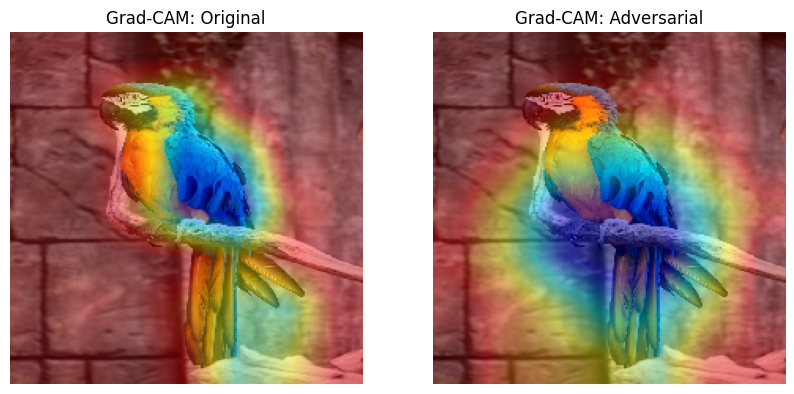

In [5]:
heatmap_orig = compute_gradcam(model, input_tensor)
heatmap_adv = compute_gradcam(model, adv_input)
titles = ['Grad-CAM: Original', 'Grad-CAM: Adversarial']
show_side_by_side_gradcam(heatmap_orig, heatmap_adv, img_array, titles)

## 6. Integrated Gradients Functions and Visualization Utilities

In [6]:
def interpolate(baseline, input_tensor, steps=50):
    alphas = tf.linspace(0.0, 1.0, steps + 1)
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    return baseline + alphas_x * (input_tensor - baseline)

def integrated_gradients(model, input_tensor, target_index, steps=50, baseline=None):
    if baseline is None:
        baseline = tf.zeros(shape=input_tensor.shape)
    interpolated = interpolate(baseline, input_tensor, steps)
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        logits = model(interpolated)
        probs = logits[:, target_index]
    grads = tape.gradient(probs, interpolated)
    avg_grads = tf.reduce_mean(grads, axis=0)
    ig = (input_tensor - baseline) * avg_grads
    return tf.reduce_sum(tf.abs(ig), axis=-1)[0]

def show_side_by_side_ig(ig_orig, ig_adv, titles):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    for i, ig_map in enumerate([ig_orig, ig_adv]):
        axes[i].imshow(ig_map, cmap='plasma')
        axes[i].set_title(titles[i])
        axes[i].axis('off')
    plt.show()

## 7. Compute and Visualize IG for Original and Adversarial Images

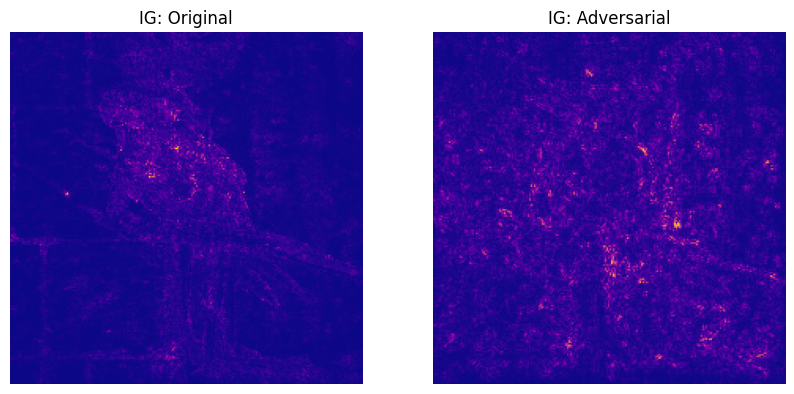

In [7]:
target_class_orig = tf.argmax(model(input_tensor)[0])
target_class_adv = tf.argmax(model(adv_input)[0])

ig_orig = integrated_gradients(model, input_tensor, target_class_orig)
ig_adv = integrated_gradients(model, adv_input, target_class_adv)

titles = ['IG: Original', 'IG: Adversarial']

show_side_by_side_ig(ig_orig, ig_adv, titles)

## 8. Compute and Visualize Grad-CAM Using Softmax

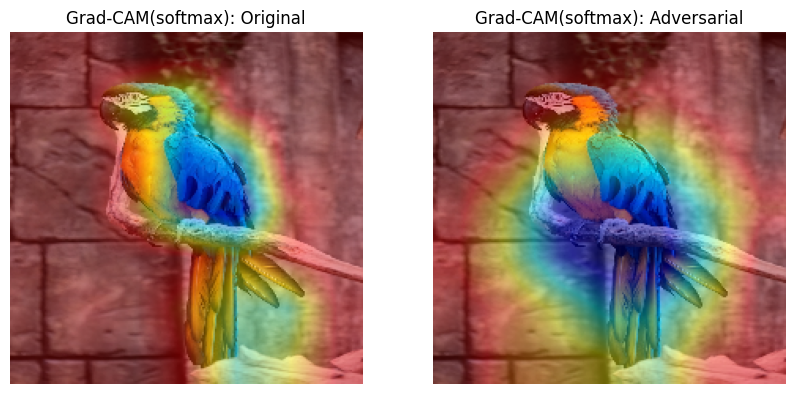

In [8]:
def compute_gradcam_softmax(model, img_tensor, layer_name='conv5_block3_out'):
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        class_idx = tf.argmax(predictions[0])
        probs = tf.nn.softmax(predictions)
        loss = probs[:, class_idx]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_sum(pooled_grads * conv_outputs, axis=-1)[0]
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

heatmap_softmax_orig = compute_gradcam_softmax(model, input_tensor)
heatmap_softmax_adv = compute_gradcam_softmax(model, adv_input)
titles = ['Grad-CAM(softmax): Original', 'Grad-CAM(softmax): Adversarial']
show_side_by_side_gradcam(heatmap_softmax_orig, heatmap_softmax_adv, img_array, titles)

## 9. Compute and Visualize Integrated Gradients Using Pre Softmax

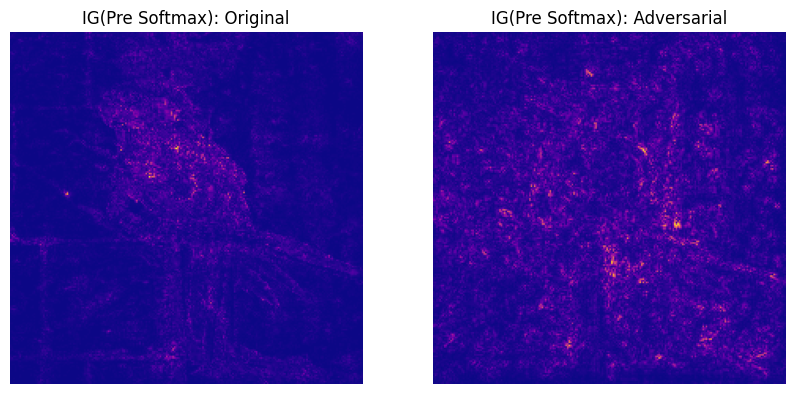

In [9]:
def ig_logits(model, input_tensor, target_index, steps=50, baseline=None):
    if baseline is None:
        baseline = tf.zeros(shape=input_tensor.shape)
    interpolated = interpolate(baseline, input_tensor, steps)
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        logits = model(interpolated)  # ← no softmax
        class_prob = logits[:, target_index]
    grads = tape.gradient(class_prob, interpolated)
    avg_grads = tf.reduce_mean(grads, axis=0)
    ig = (input_tensor - baseline) * avg_grads
    return tf.reduce_sum(tf.abs(ig), axis=-1)[0]


ig_orig_softmax = ig_logits(model, input_tensor, target_class_orig)
ig_adv_softmax = ig_logits(model, adv_input, target_class_adv)
titles = ['IG(Pre Softmax): Original', 'IG(Pre Softmax): Adversarial']
show_side_by_side_ig(ig_orig_softmax, ig_adv_softmax, titles)